# First PINN Neural Network

This notebook is used to try to define a simple PINN neural network. It is inspired by this repository https://github.com/lukerlars/PiNN_masterthesis, in particular by this code https://github.com/lukerlars/PiNN_masterthesis/blob/master/quick_example.py. The goal is to understand more in detail how they work and how to implement them. As we know, PINNs need to have a loss function that is composed of two parts: the first one is the loss function that we want to minimize, the second one is the loss function of the physics constraints. The total loss function is then defined as:

$$
\mathcal{L} = \mathcal{L}_{\text{data}} + \mathcal{L}_{\text{physics}}
$$

The network used for this notebook is really simple. It is composed of 3 layers:
- **torch.nn.Linear(1,20)**: The first layer takes an input tensor of size (batch_size, 1) and produces an output tensor of size (batch_size, 20). The weight matrix of this layer has a shape of (20, 1), indicating that it performs a linear transformation mapping the input features to 20 output features
- **torch.nn.Tanh()**: This layer initializes the hyperbolic tangent activation function (tanh)
- **torch.nn.Linear(20,1)**: This layer takes an input tensor of size (batch_size, 20) and produces an output tensor of size (batch_size, 1). The weight matrix of this layer has a shape of (1, 20), indicating that it performs a linear transformation mapping the 20 input features to a single output feature

In [29]:
import torch 
import matplotlib.pyplot as plt
import numpy as np


class Neural_net(torch.nn.Module):
    def __init__(self):
        super(Neural_net, self).__init__()

        self.layer1 = torch.nn.Linear(1,20)
        self.tanh = torch.nn.Tanh()
        self.layer2 = torch.nn.Linear(20,1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.tanh(x)
        x = self.layer2(x)
        return x

Now that the network behind the PINN has been defined, let's understand which equations we want to solve. This is the equation that we want to solve:

$$
\frac{d\Psi}{dx} + (x + \frac{1 + 3x^2}{1 + x + x^3}) \Psi = x^3 + 2x + x^2 \frac{1 + 3x^2}{1 + x + x^3}
$$

The two coefficient of the differential equations are:

$$
f_1(x) = x + \frac{1 + 3x^2}{1 + x + x^3}
$$

$$
f_2(x) = x^3 + 2x + x^2 \frac{1 + 3x^2}{1 + x + x^3}
$$

In [30]:
class Simple_pinn():
        def coef(self, x):
                return (x + (1+3*x**2)/(1+x+x**3))

        def expr(self, x):
                return x**3 + 2*x + x**2*((1+3*x**2)/(1+x+x**3))

Now it's possible to define the loss function. First, we need to define the predicted value given a set of input. This is represented by the `pred` variable. Then, we need to compute the differential of the prediction, since we have the term $\frac{d\Psi}{dx}$. This is saved in the `dpred` variable.

Then we can compute the loss caused by the differential equation and the loss caused by the intial condition. `z0` represents the loss caused by the differential equation, while `ic` represents the loss with respect to the initial condition. The total loss is then computed as the sum of the two losses.

In [31]:
class Simple_pinn(Simple_pinn):
    def de_loss(self):
        pred = self.model(self.x_domain)
        dpred = self.wrap_torch_grad(pred, self.x_domain) 
        
        z0 = torch.mean((dpred + self.coef(self.x_domain)*pred -self.expr(self.x_domain))**2)
        ic = (self.c0 - pred[0])**2
        
        return z0 + ic

Another thing that we need to define is the true solution of the differential equation. This is used to compute the error between the predicted solution and the true solution. This differential equations has an analytical solution, which is:

$$
\Psi(x) = x^2 + \frac{e^{\frac{-x^2}{2}}}{1 + x + x^3}
$$


In [32]:
class Simple_pinn(Simple_pinn):
    def true_sol(self,x):
        return x**2 + np.exp(-x**2/2)/(1+x+x**3)

# PINN Definition

Let's now define the actual class for the PINN. The model, is the one we already defined. What it could be misleading is the use of the following variables:
- `x_domain`: This is the input used for the computation of the loss function
- `some_xs`: This is the input used for the computation of the analytical solution
- `some_other_xs`: This is the input used for the computation of the predicted solution
On the other hand, `c0` represents the initial condition. 

The function `wrap_torch_grad` executes the derivative of the function `f` with respect to the variable `x`. 

In [33]:
class Simple_pinn(Simple_pinn):
    def __init__(self, epochs):
        self.model = Neural_net() # Simple 1-layer PyTorch neural network model
        self.some_xs = np.linspace(0,2,10)
        self.some_other_xs = torch.linspace(0,2,100,requires_grad=True).reshape(-1,1) 

        self.x_domain =torch.linspace(0,1,100,requires_grad=True).reshape(-1,1) 
        self.optimizer = torch.optim.LBFGS(params = self.model.parameters(), lr =0.001, max_iter=200)
        self.c0 = 1.0
        self.epochs = epochs
    
    def wrap_torch_grad(self, f,x):
        return torch.autograd.grad(f,x,
        grad_outputs=torch.ones_like(x),
        retain_graph=True,
        create_graph=True)[0]

The train loop is really simple and it just a loop over the epochs. For each epoch, the loss is computed and the optimizer is used to update the weights of the network.

In [34]:
class Simple_pinn(Simple_pinn):
    def closure(self):
        self.optimizer.zero_grad()
        loss = self.de_loss()
        loss.backward()
        return loss
    
    def train(self):
        self.model.train()    
        for epoch in range(self.epochs):
            self.optimizer.step(closure=self.closure)
            print(self.de_loss())
        plt.plot(self.some_other_xs.detach(), self.model(self.some_other_xs).detach(), label = 'pred')
        plt.scatter(self.some_xs, [self.true_sol(x) for x in self.some_xs], label = 'analytic')
        plt.legend()
        plt.grid()
        plt.show()
    

            

tensor([1.1276], grad_fn=<AddBackward0>)
tensor([0.6406], grad_fn=<AddBackward0>)
tensor([0.4943], grad_fn=<AddBackward0>)
tensor([0.2173], grad_fn=<AddBackward0>)
tensor([0.0569], grad_fn=<AddBackward0>)
tensor([0.0272], grad_fn=<AddBackward0>)
tensor([0.0116], grad_fn=<AddBackward0>)
tensor([0.0041], grad_fn=<AddBackward0>)
tensor([0.0015], grad_fn=<AddBackward0>)
tensor([0.0006], grad_fn=<AddBackward0>)


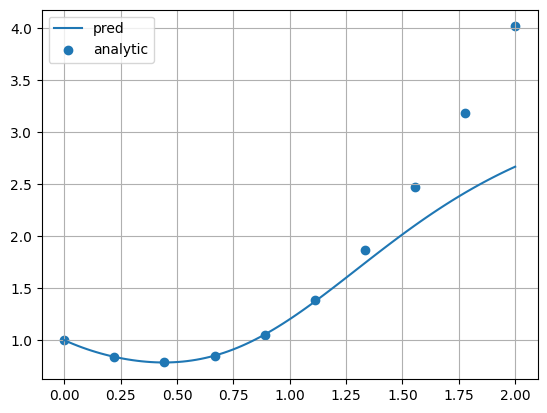

In [35]:
instance = Simple_pinn(epochs= 10)
instance.train()